<a href="https://colab.research.google.com/github/nhuang37/ScalarModel/blob/main/Pointcloud_lightweight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Utils

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cd '/content/drive/MyDrive/JHU/Group'

In [3]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.2/709.2 kB 32.3 MB/s eta 0:00:00


In [4]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import numpy as np
import networkx as nx
import copy
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from collections import Counter
from networkx.generators.nonisomorphic_trees import nonisomorphic_trees
import os
from sympy.utilities.iterables import multiset_permutations
import itertools
from itertools import permutations
import ot
import scipy as sp

np.set_printoptions(precision=4, suppress=True)

In [ ]:
def get_permutations(n, hashable=False):
  '''
  Return a list of n! permutations
  '''
  Perms = []
  for m in itertools.permutations(np.eye(n)):
    if hashable:
      Perms.append(hash(np.array(m).tobytes()))
    else:
      Perms.append(np.array(m))

  return Perms

In [ ]:
def construct_nx_graph(edge_list):
  '''
  Return networkx graph using a list of edge tuples
  '''
  G = nx.Graph()
  G.add_edges_from(edge_list)
  return G

def draw_nx_tree(G, pos):
  nx.draw_networkx(G, pos, with_labels = True)
  plt.show()


def compute_eigen(G):
  '''
  Given a graph G (networkx), compute the eigendecomposition of its adjacency
  '''
  A = nx.to_numpy_array(G)
  s, u = np.linalg.eigh(A)
  idx = s.argsort()[::-1]   
  s = s[idx]
  u = u[:,idx]
  return s, u

### Ben's invariant features: 

In [8]:
def arrayToMultiset(arr, decimals=4):
  '''
  Input: 1D numpy array
  Output: a multiset of elements 
  '''
  unique, counts = np.unique(arr.round(decimals), return_counts=True)
  return dict(zip(unique, counts))

def upper_tri_masking(A):
  '''
  return the upper triangular values of matrix A (without diagonal)
  '''
  m = A.shape[0]
  r = np.arange(m)
  mask = r[:,None] < r
  return A[mask]

def row_sum(row, row_idx, decimals=4):
  '''
  Input: row (of matrix of dot-product), row_idx
  Return sum_{j \neq row_idx} row[row_idx] * row[j]
  '''
  sum = 0
  n = row.shape[0]
  for j in range(n):
    if j == row_idx:
      continue
    sum += row[row_idx] * row[j]
  return sum.round(decimals)

def get_fs(U, decimals=4):
  '''
  Input: U being n by k point clouds
  Output: return an array with n + (n choose 2) + 1 coordinates, where
  : first n-dim being the SORTED self dots;
  : next (n choose 2)-dim being the SORTED cross dots;
  : last dim being the f*
  '''
  n = U.shape[0]
  num_cross = int(n*(n-1)/2)
  K = n + num_cross + 1
  invariants = np.zeros(K)
  #compute the dot product
  DOT = U @ U.T
  #SORTED self dots
  invariants[:n] = np.sort(np.diagonal(DOT))
  #SORTED cross dots
  invariants[n:(n+num_cross)] = np.sort(DOT[np.triu_indices(n, 1)])
  #f*
  invariants[-1] = np.array([DOT[i,i]*(DOT[i].sum()-DOT[i, i]) for i in range(n)]).sum()
  return invariants

def procrustesMatcher(U, U_t, decimals=4):
  '''
  Input: U , U_t both n by k eigenvector matrices, with n rows and k orthornormal columns
  Re-index the rows in U as a_i, rows in U_t as b_i, for i = 1, ..., n
  Check 3 invariants
  '''
  n = U.shape[0]
  inv_U = get_fs(U)
  inv_U_t = get_fs(U_t)

  return np.all(inv_U == inv_U_t)

### Gromov-Wasserstein distance

In [10]:
def compute_GW(X, Y):
  '''
  Assume X, Y are pointclouds with n points (rows) in d dimension (columns)
  '''
  #check if the GW distance for this pair of point clouds is zero!
  n_samples = X.shape[0]

  #compute pairwise distance for pointclouds X and Y
  C1 = sp.spatial.distance.cdist(X, X)
  C2 = sp.spatial.distance.cdist(Y, Y)
  #normalize the pairwise distance
  C1 /= C1.max()
  C2 /= C2.max()
  #assume uniform distribution on the points
  p = ot.unif(n_samples)
  q = ot.unif(n_samples)

  gw0, log0 = ot.gromov.gromov_wasserstein(
      C1, C2, p, q, 'square_loss', symmetric=True, verbose=True, log=True)
  
  return gw0, log0

def plot_GW_transport(gw0, log0):
  '''
  Input: gw0 - OT transport plan (n by n matrix)
  Input: log0 - GW distance
  '''
  dist = log0['gw_dist']
  print(f'Gromov-Wasserstein distances: {dist:.4f}')

  plt.figure(1, (10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(gw0, cmap='jet')
  plt.title('Gromov Wasserstein')
  plt.show()

### Examples from Hordan et al, Pozdnyakove & Ceriotti (2022)

- Ours fail (BAD SET EXAMPLES FOUND!)
- Question: f* must be summing over all $i \neq j$? not $i < j$?

#### Example 1: $n=5, d=3$
- Multiset of multiset of distances are the same in $X, Y$
- In the family $R^{3\times n}_{distinct}$
- 1-GEO with $1$ iteration fails but $2$ iteration succeed 

In [11]:
#here we consider 3D point clouds
#Example 1: https://arxiv.org/pdf/2001.11696.pdf, figure S4 - panel A
#(x,y,z) 3D coordinates
X = np.array([[-2, 0, -2],
              [-1, -1, 0],
              [0, 1, 1], #the blue dot (special)
              [1, 1, 0],
              [2, 0, 2]])
Y = np.array([[-2, 0, -2],
              [-1, -1, 0],
              [0, 1, -1], #the flip symmetric blue dot
              [1, 1, 0],
              [2, 0, 2]])

In [12]:
X @ X.T

array([[ 8,  2, -2, -2, -8],
       [ 2,  2, -1, -2, -2],
       [-2, -1,  2,  1,  2],
       [-2, -2,  1,  2,  2],
       [-8, -2,  2,  2,  8]])

In [13]:
#key diff: row 1, 5 (row 2,3, 4 are the same)
#let's hand compute what f* looks like for X
8*(-10) + 2 * (-3) + 2 * (0) + 2 * (-1) + 8 * (-6)

-136

In [14]:
Y @ Y.T

array([[ 8,  2,  2, -2, -8],
       [ 2,  2, -1, -2, -2],
       [ 2, -1,  2,  1, -2],
       [-2, -2,  1,  2,  2],
       [-8, -2, -2,  2,  8]])

In [15]:
#let's hand compute what f* looks like for Y
8*(-6) + 2 * (-3) + 2 * (0) + 2* (-1) + 8 * (-10)

-136

In [16]:
procrustesMatcher(X, Y, decimals=5)

True

- Demonstrate how the multiset of multiset of distances is the same for $X$ and $Y$

In [17]:
###note but using neighbors' pairwise distance can separate them
def pairwise_dist(U):
  dist = []
  n = U.shape[0]
  for i in range(n):
    local_dist = np.zeros(n)
    for j in range(n):
      local_dist[j] = np.linalg.norm(U[i] - U[j])
    
    dist.append(np.sort(local_dist))
  return dist

print(np.sort(pairwise_dist(X)))
print(np.sort(pairwise_dist(Y)))
#note the 1-geo-WL fails (due to same distance degree histogram), 
#HOWEVER, 2-iterations can separate because
#we have access to iterated (distance) degree sequence
#AND the each point has a distinct degree(distance) neighborhood (almost like one-hot encoding of each node, 
#or think about breaking the perfect triangle by three different edge weights)
#see Thm 2.1 in Hordan et al.

[[0.     2.4495 3.7417 3.7417 5.6569]
 [0.     2.4495 2.4495 2.8284 3.7417]
 [0.     1.4142 2.4495 2.4495 3.7417]
 [0.     1.4142 2.4495 2.8284 3.7417]
 [0.     2.4495 2.4495 3.7417 5.6569]]
[[0.     2.4495 2.4495 3.7417 5.6569]
 [0.     2.4495 2.4495 2.8284 3.7417]
 [0.     1.4142 2.4495 2.4495 3.7417]
 [0.     1.4142 2.4495 2.8284 3.7417]
 [0.     2.4495 3.7417 3.7417 5.6569]]


In [18]:
gw1, log1 = compute_GW(X, Y)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.575214e-01|0.000000e+00|0.000000e+00
    1|1.669697e-02|8.434131e+00|1.408245e-01
    2|1.669697e-02|0.000000e+00|0.000000e+00


In [19]:
gw1

array([[0. , 0. , 0. , 0. , 0.2],
       [0. , 0.2, 0. , 0. , 0. ],
       [0. , 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0.2, 0. ],
       [0.2, 0. , 0. , 0. , 0. ]])

Gromov-Wasserstein distances: 0.0167


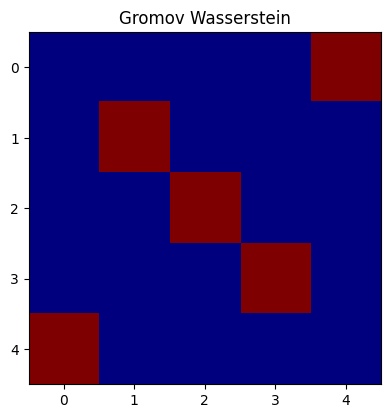

In [ ]:
plot_GW_transport(gw1, log1)

#### Example 2: $n=7, d=3$

In [ ]:
X2 = np.array([
    [-2, 0, -2],
    [-1, -1, 0],
    [-1, 2, 0],
    [0, 0, 1], #the symmetry breaking blue point
    [0, 0, -1],
    [1, 1, 0],
    [1, 2, 0],
    [2, 0, 2]
])

Y2 = np.array([
    [-2, 0, -2],
    [-1, -1, 0],
    [-1, 2, 0],
    [0, 0, -1], ##the symmetry breaking blue point
    [0, 0, -1],
    [1, 1, 0],
    [1, 2, 0],
    [2, 0, 2]
])

In [ ]:
gw2, log2 = compute_GW(X2, Y2)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.089732e-01|0.000000e+00|0.000000e+00
    1|1.785354e-02|5.103729e+00|9.111962e-02
    2|1.785354e-02|0.000000e+00|0.000000e+00


In [ ]:
print(gw2)

[[0.    0.    0.    0.    0.    0.    0.    0.125]
 [0.    0.125 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.125 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.125 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.125 0.    0.   ]
 [0.    0.    0.    0.    0.125 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.125 0.   ]
 [0.125 0.    0.    0.    0.    0.    0.    0.   ]]


Gromov-Wasserstein distances: 0.0179


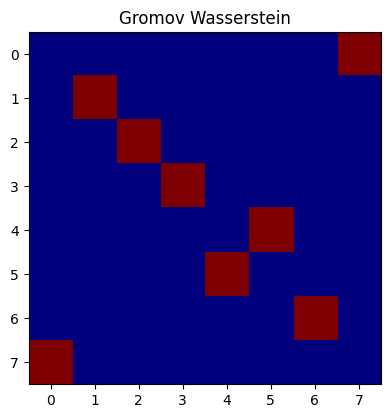

In [ ]:
plot_GW_transport(gw2, log2)

### Benchmark dataset: [QM7b](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM7b.html)
- Source: https://arxiv.org/pdf/1703.00564.pdf (Table 10)
- A collection of 7,211 molecular graphs (i.e., represented as fully connected graphs describing the [Coulomb Matrix](https://singroup.github.io/dscribe/0.3.x/tutorials/coulomb_matrix.html#invariance), a $n \times n$ symmetric matrix, invariant to translation/rotation, and requires models to be permutation invariant.
- Task: predicting electronic
properties of these molecule graphs
- Note: molecules are graphs with varying sizes (deepset needed, see below)



In [6]:
import os.path as osp 
import torch 
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset, zinc, QM7b
from torch_geometric.utils import to_networkx, homophily, erdos_renyi_graph, stochastic_blockmodel_graph, scatter, loop
from torch_geometric.nn import GINConv, global_mean_pool, global_add_pool
from torch_geometric.nn.aggr import DeepSetsAggregation #key to implement DeepSet input (batch_features, batch_index)
from torch_geometric.nn.models import MLP
import torch.nn as nn
from torch.nn import Linear, Sequential, ReLU, Dropout
import torch_geometric.transforms as T
import torch.nn.functional as F

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [7]:
#step 1: pre-compute fs in dataset
#step 2: modify collate_fn in dataloader to store the edge batch index

def get_fs(data):
  '''
  input: Data (graph) from pytorch geometric dataset
    edge_index=[num_edges]
    edge_attr=[num_edges]
    y=[num_targets]
    x=[num_nodes, 1]

  output: updated DataBatch with the following additional invariant features
   f_d is the set of diagonal edge attributes, 
   f_o is the set of off-diagonal (upper) edge attributes, 
   f_star is \sum_{i \neq j} X_ii X_ij where X is the n by n edge attribute graph
  '''
  #get f_d, f_o
  loop_mask = data.edge_index[0] == data.edge_index[1]
  data.f_d = data.edge_attr[loop_mask].unsqueeze(1)
  data.f_o = data.edge_attr[~loop_mask].unsqueeze(1)

  #get f_star
  sum_fo = scatter(data.edge_attr, data.edge_index[1], dim=0) #sum over rows 
  data.f_star = (data.f_d.squeeze(1) @ ( sum_fo - data.f_d.squeeze(1))).reshape((1,1))
  return data


In [8]:
target=1

class Univariate(object):
    def __call__(self, data):
        # Specify target.
        data.y = data.y[:, target:(target+1)]
        return data

path = "/content/drive/MyDrive/JHU/Group/dataset"
#func = T.Constant()

dataset = QM7b(path, pre_transform=get_fs, transform=T.Compose([Univariate()]))
dataset.name = "QM7b"


In [9]:
dataset[0]

Data(edge_index=[2, 25], edge_attr=[25], y=[1, 1], f_d=[5, 1], f_o=[20, 1], f_star=[1, 1], num_nodes=5)

In [68]:
#try out edge batch
loader = DataLoader(dataset, batch_size=2, follow_batch=['f_d', 'f_o']) #add the keys such that we need to create batch index pointers

In [69]:
for data in loader:
  print(data)
  break

DataBatch(edge_index=[2, 89], edge_attr=[89], y=[2, 1], f_d=[13], f_d_batch=[13], f_d_ptr=[3], f_o=[76], f_o_batch=[76], f_o_ptr=[3], f_star=[2], num_nodes=13, batch=[13], ptr=[3])


In [131]:
#check QM7b graph size profile
sizes = []
for data in dataset:
  sizes.append(data.num_nodes)


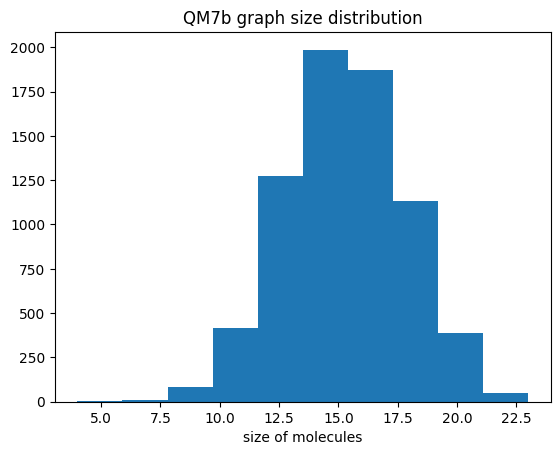

In [132]:
plt.hist(sizes)
plt.xlabel("size of molecules")
plt.title("QM7b graph size distribution")
plt.show()

### Model
- Invariant feature map/extraction: $X \to (, \{f^o \}, f^*)$
- Learn MLP(deep_set_1( $\{f^d \}$ , deep_set_2($\{f^d \}$), MLP_s($f^*$)), where
  - deep_set_i, MLP_s: input_dim = 1, output_dim = hid_dim
  - MLP: input_dim = hid_dim + hid_dim + hid_dim, output_dim = num_classes (invariant classification) / 1 (invariant scalar regression)
- Deepset, proposed in [Zaheer et al. ](https://arxiv.org/pdf/1703.06114.pdf), can universally approximate continuous functions on sets (where elements are from countable domain), by choosing suitable $\rho, \phi$, and maps a input set $X$ via
$$
\rho ( \sum_{x \in X} \phi(x) )
$$
We use the Deepset implementation in Pytorch Geometric, which can apply to batch of sets

In [11]:
class ScalarModel(torch.nn.Module):
    def __init__(self, hid_dim, out_dim, dropout=0):
        super(ScalarModel, self).__init__()
        #Deepset for diagonal scalars
        phi_d = MLP([1,hid_dim, hid_dim*2], dropout=[dropout]*2)
        rho_d = MLP([hid_dim*2, hid_dim], dropout=[dropout]*1)
        self.deepset_d = DeepSetsAggregation(local_nn=phi_d, global_nn=rho_d)
        #Deepset for off-diagonal scalars
        phi_o = MLP([1,hid_dim, hid_dim*2], dropout=[dropout]*2)
        rho_o = MLP([hid_dim*2, hid_dim], dropout=[dropout]*1)
        self.deepset_o = DeepSetsAggregation(local_nn=phi_o, global_nn=rho_o) 
        #MLP_s for f_star
        self.MLP_s = MLP([1,hid_dim, hid_dim], dropout=[dropout]*2) 
        #MLP for (Deepset(f_d), Deepset(f_o), f_star)
        self.MLP_out = MLP([hid_dim*3, hid_dim, out_dim], dropout=[dropout]*2)

    def reset_parameters(self):
        for net in [self.deepset_d, self.deepset_o, self.MLP_s, self.MLP_out]:
            net.reset_parameters()
    
    def forward(self, data):
        out_d = self.deepset_d(data.f_d, data.f_d_batch) # bs x hid_dim
        out_o = self.deepset_o(data.f_o, data.f_o_batch) # bs x hid_dim
        out_star = self.MLP_s(data.f_star) #bs x hid_dim
        #concat and output final embedding
        out = self.MLP_out(torch.concat([out_d, out_o, out_star], dim=-1)) # bs x hid_dim*3 -> bs x out_dim
        return out

#### Training

In [14]:
#code adapated from https://github.com/nhuang37/untrain_MPNN/blob/main/GNN_untrained/auxiliarymethods/gnn_evaluation.py

def train(train_loader, model, optimizer, device):
    model.train()
    loss_all = 0

    lf = torch.nn.L1Loss()

    for data in train_loader:
        #print(data)
        data = data.to(device)
        optimizer.zero_grad()
        loss = lf(model(data), data.y)

        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return (loss_all / len(train_loader.dataset))


def test(loader, model, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        error += (model(data) - data.y).abs().sum().item()
    return error / len(loader.dataset)


# 10-CV for NN training and hyperparameter selection.
def nn_evaluation(dataset, hid_dim, out_dim, max_num_epochs=200, batch_size=128, start_lr=0.01, min_lr = 0.000001, factor=0.5, patience=50,
                       num_repetitions=5, all_std=True, verbose=True, dropout=0):
    #reproducibility
    torch.manual_seed(0)

    # Set device.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    test_all = []
    test_complete = []

    for i in range(num_repetitions):
        # Test acc. over all folds.
        test_error = []
        kf = KFold(n_splits=10, shuffle=True, random_state=i)
        #dataset.shuffle()

        for train_index, test_index in kf.split(list(range(len(dataset)))):
            # Sample 10% split from training split for validation.
            train_index, val_index = train_test_split(train_index, test_size=0.1, random_state=i)
            best_val_error = None
            best_test = None

            # Split data.
            train_dataset = dataset[train_index.tolist()]
            val_dataset = dataset[val_index.tolist()]
            test_dataset = dataset[test_index.tolist()]

            # Prepare batching. (follow_batch: batchify both f_d, f_o)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, follow_batch=['f_d', 'f_o'])
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, follow_batch=['f_d', 'f_o'])
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, follow_batch=['f_d', 'f_o']) #reproducible

            # Collect val. and test acc. over all hyperparameter combinations.
            # Setup model.
            model = ScalarModel(hid_dim, out_dim, dropout).to(device)
            model.reset_parameters()

            optimizer = torch.optim.Adam(model.parameters(), lr=start_lr)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                                    factor=factor, patience=patience,
                                                                    min_lr=0.0000001)
            for epoch in range(1, max_num_epochs + 1):
                lr = scheduler.optimizer.param_groups[0]['lr']
                loss = train(train_loader, model, optimizer, device)
                val_error = test(val_loader, model, device)
                scheduler.step(val_error)

                if best_val_error is None or val_error <= best_val_error:
                    best_val_error = val_error
                    best_test = test(test_loader, model, device)
                if verbose and (epoch+1) % 50 == 0:
                    print('Epoch: {:03d}, LR: {:.7f}, Loss: {:.4f},'
                      'Val MAE: {:.4f}'.format(epoch, lr, loss, val_error))
                # Break if learning rate is smaller 10**-6.
                if lr < min_lr:
                    break

            test_error.append(best_test)
            if all_std:
                test_complete.append(best_test)
        test_all.append(float(np.array(test_error).mean()))

    if all_std:
        return (np.array(test_all).mean(), np.array(test_all).std(),
                np.array(test_complete).std())
    else:
        return (np.array(test_all).mean(), np.array(test_all).std())

In [15]:
hid_dim = 32
out_dim = 1
dropout = 0

mae, std, std_all = nn_evaluation(dataset, hid_dim, out_dim, max_num_epochs=300, batch_size=128, 
                                  start_lr=0.02, min_lr = 0.000001, factor=0.8, patience=10,
                       num_repetitions=1, all_std=True, verbose=True, dropout=dropout)

Epoch: 049, LR: 0.0128000, Loss: 2.0406,Val MAE: 2.3476
Epoch: 099, LR: 0.0102400, Loss: 1.9483,Val MAE: 2.6001
Epoch: 149, LR: 0.0041943, Loss: 1.8555,Val MAE: 2.2481
Epoch: 199, LR: 0.0013744, Loss: 1.8421,Val MAE: 1.8535
Epoch: 249, LR: 0.0007037, Loss: 1.8368,Val MAE: 1.7303
Epoch: 299, LR: 0.0003603, Loss: 1.8229,Val MAE: 1.7858
Epoch: 049, LR: 0.0128000, Loss: 1.9783,Val MAE: 2.0240
Epoch: 099, LR: 0.0081920, Loss: 1.9248,Val MAE: 2.0016
Epoch: 149, LR: 0.0026844, Loss: 1.8680,Val MAE: 2.4906
Epoch: 199, LR: 0.0013744, Loss: 1.8214,Val MAE: 2.1821
Epoch: 249, LR: 0.0007037, Loss: 1.8248,Val MAE: 1.8811
Epoch: 299, LR: 0.0002882, Loss: 1.8352,Val MAE: 1.7961
Epoch: 049, LR: 0.0128000, Loss: 2.0100,Val MAE: 3.1678
Epoch: 099, LR: 0.0065536, Loss: 1.9064,Val MAE: 2.0105
Epoch: 149, LR: 0.0033554, Loss: 1.8369,Val MAE: 1.8075
Epoch: 199, LR: 0.0026844, Loss: 1.8129,Val MAE: 1.9352
Epoch: 249, LR: 0.0010995, Loss: 1.7837,Val MAE: 1.7826
Epoch: 299, LR: 0.0005629, Loss: 1.7796,Val MAE:

In [16]:
print(f"Target_variable={target}, Test_MAE={mae} (with std={std_all})")
#reference benchmark: Kernel-ridge-regression 1.83; Deep-Tensor-Neural-Network 1.26

Target_variable=1, Test_MAE=1.8230250762403977 (with std=0.0913251640471234)


### Benchmark dataset: ModelNet40
- The most popular dataset for pointcloud classification
- Can benchmark against Deepset and PointNet (old SOTA models): e,g, https://github.com/manzilzaheer/DeepSets/blob/master/PointClouds/run.py
- BUG: relatively large point clouds, our methods need $O(n^2)$ computation whereas Deepset/PointNet can do $O(n)$ (since the point clouds literally live in $d=3$)